<h1> Circuit Node Classification using Graph Convolutional Networks </h1>

In [1]:
#importing dependencies

import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# parse the data

In [2]:
import sys
sys.path.append('../lib')
from data_pre_processing import load_data
sys.path.remove('../lib')
A, X, labels = load_data('c6288', '../data/output')
N = X.shape[0] #the number of nodes
F = X.shape[1]
num_classes = len(set(labels))
print('X shape: ', X.shape)
print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

(6288, 6288)
(6288, 4)
X shape:  (6288, 4)

Number of nodes (N):  6288

Number of features (F) of each node:  4

Categories:  {'ho', 'eo'}


<h3> Training, validation, and test then set the mask</h3>

In [3]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [4]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

<h3>Show Data Distribution</h3>

In [5]:
print("All Data : \n{}".format(Counter(labels)))
print("Training Data: \n{}".format(Counter([labels[i] for i in train_idx])))
print("Validation Data : \n{}".format(Counter([labels[i] for i in val_idx])))

All Data : 
Counter({'eo': 5442, 'ho': 846})
Training Data: 
Counter({'eo': 20, 'ho': 20})
Validation Data : 
Counter({'eo': 500})


<h3>Convert the labels to one hot encoding</h3>

In [6]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

<h2> Fully-Connected Neural Networks </h2>

<h3>Building and Training FNN</h3>

In [7]:
es_patience = 10
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 1s 639ms/step - loss: 0.1927 - acc: 0.5750 - val_loss: 33.0013 - val_acc: 0.0000e+00
Epoch 2/200
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 33ms/step - loss: 0.1276 - acc: 0.5000 - val_loss: 45.5599 - val_acc: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 43ms/step - loss: 0.1860 - acc: 0.5000 - val_loss: 46.8256 - val_acc: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 40ms/step - loss: 0.1981 - acc: 0.5000 - val_loss: 40.9684 - val_acc: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 37ms/step - loss: 0.1781 - acc: 0.5000 - val_loss: 29.4239 - val_acc: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 44ms/step - loss: 0.1296 - acc: 0.5250 - val_loss: 14.0451 - val_acc: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0910 - acc: 0.5000 - val_loss: 12.5455 - va

In [8]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

FCNN Classification Report: 
               precision    recall  f1-score   support

          eo       0.99      0.45      0.62       937
          ho       0.10      0.94      0.19        63

    accuracy                           0.48      1000
   macro avg       0.55      0.69      0.40      1000
weighted avg       0.93      0.48      0.59      1000



<h3>Get hidden layer representation for FNN</h3>

In [9]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

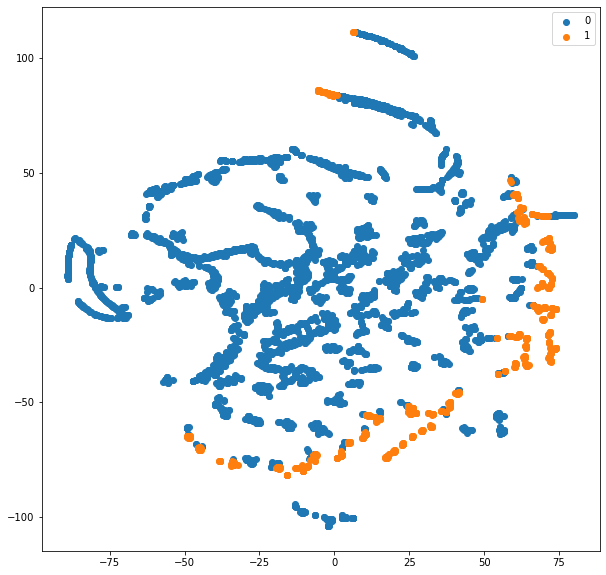

In [11]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
plot_tSNE(labels_encoded,x_tsne)